In [16]:
import numpy as _np
import numba as _numba
import lmfit as _lmfit
import h5py as _h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import iv as _iv
import pandas as _pd

def loadlocs(path):    
    with _h5py.File(path, 'r') as locs_file:
        locs = locs_file['locs'][...]
    locs = _np.rec.array(locs, dtype=locs.dtype)    # Convert to rec array with fields as attributes
    return locs

def nena(locs, callback=None):
    bin_centers, dnfl_ = next_frame_neighbor_distance_histogram(locs, callback)

    def func(d, a, s, ac, dc, sc):
        f = a * (d / s**2) * _np.exp(-0.5 * d**2 / s**2)
        fc = ac * (d / sc**2) * _np.exp(-0.5 * (d**2 + dc**2) / sc**2) * _iv(0, d * dc / sc)
        return f + fc

    pdf_model = _lmfit.Model(func)
    params = _lmfit.Parameters()
    area = _np.trapz(dnfl_, bin_centers)
    median_lp = _np.mean([_np.median(locs.lpx), _np.median(locs.lpy)])
    params.add('a', value=area/2, min=0)
    params.add('s', value=median_lp, min=0)
    params.add('ac', value=area/2, min=0)
    params.add('dc', value=2*median_lp, min=0)
    params.add('sc', value=median_lp, min=0)
    result = pdf_model.fit(dnfl_, params, d=bin_centers)
    return result, result.best_values['s']


def next_frame_neighbor_distance_histogram(locs, callback=None):
    locs.sort(kind='mergesort', order='frame')
    frame = locs.frame
    x = locs.x
    y = locs.y
    if hasattr(locs, 'group'):
        group = locs.group
    else:
        group = _np.zeros(len(locs), dtype=_np.int32)
    bin_size = 0.001
    d_max = 1.0
    return _nfndh(frame, x, y, group, d_max, bin_size, callback)


def _nfndh(frame, x, y, group, d_max, bin_size, callback=None):
    N = len(frame)
    bins = _np.arange(0, d_max, bin_size)
    dnfl = _np.zeros(len(bins))
    one_percent = int(N / 100)
    starts = one_percent * _np.arange(100)
    for k, start in enumerate(starts):
        for i in range(start, start + one_percent):
            _fill_dnfl(N, frame, x, y, group, i, d_max, dnfl, bin_size)
        if callback is not None:
            callback(k+1)
    bin_centers = bins + bin_size / 2
    return bin_centers, dnfl


@_numba.jit(nopython=True)
def _fill_dnfl(N, frame, x, y, group, i, d_max, dnfl, bin_size):
    frame_i = frame[i]
    x_i = x[i]
    y_i = y[i]
    group_i = group[i]
    min_frame = frame_i + 1
    for min_index in range(i + 1, N):
        if frame[min_index] >= min_frame:
            break
    max_frame = frame_i + 1
    for max_index in range(min_index, N):
        if frame[max_index] > max_frame:
            break
    d_max_2 = d_max**2
    for j in range(min_index, max_index):
        if group[j] == group_i:
            dx2 = (x_i - x[j])**2
            if dx2 <= d_max_2:
                dy2 = (y_i - y[j])**2
                if dy2 <= d_max_2:
                    d = _np.sqrt(dx2 + dy2)
                    if d <= d_max:
                        bin = int(d / bin_size)
                        dnfl[bin] += 1

### Load locs

In [4]:
path = './file.hdf5'

locs = loadlocs(path)

### Calculate NeNA distribution

In [5]:
bincenters, dnfl = next_frame_neighbor_distance_histogram(locs)

### Save histogram data

In [36]:
_np.savetxt("hist_data.csv", _np.c_[bincenters, dnfl], delimiter=",")

### Plot histogram data

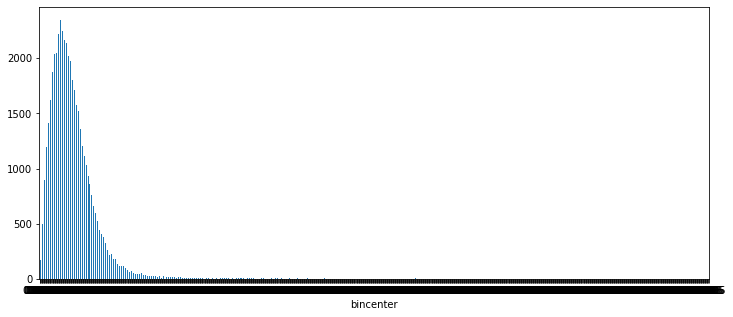

In [14]:
df_nena = _pd.DataFrame({"bincenter":bincenters[0], "nena":dnfl})
ax = df_nena.plot(x="bincenter",
                  y="nena",
                  kind="bar",
                  rot=0,
                  figsize=(12,5),
                  legend=False
                  )

### Calculate NeNA value

In [23]:
result, best_result = nena(locs)
print("Fitted NeNA value: {} px".format(best_result))

Calculated NeNA value: 0.02972179812025466 px


### Print fit parameters

In [26]:
result